# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Extracting Annotations from XML Format

In [3]:
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
xml_files[0]

'data/annotations/xmls/Russian_Blue_117.xml'

In [4]:
classes = ['cat', 'dog']
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

In [5]:
def extract_annotation(xml_file_path):
    
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['annotations'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['annotations'].append({
                     'class_id': class_id,
                     'left': xmin,
                     'top': ymin,
                     'width': xmax - xmin,
                     'height': ymax - ymin
                 })
    return annotation

In [6]:
extract_annotation(xml_files[0])

{'file': 'Russian_Blue_117.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 375, 'depth': 3}],
 'annotations': [{'class_id': 0,
   'left': 252,
   'top': 118,
   'width': 86,
   'height': 98}]}

# Visualize Data

In [7]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(a['class_id'])], font=font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return plt

def show_random_annotations(plt):
    plt.figure(figsize=(16, 16))
    for i in range(0, 9):
        index = random.randint(0, len(xml_files) - 1)
        
        annot = extract_annotation(xml_files[index])
        image_file_path = os.path.join('data/images/', annot['file'])

        plt = plot_example(plt, annot, image_file_path, 3, 3, i)
    plt.show()

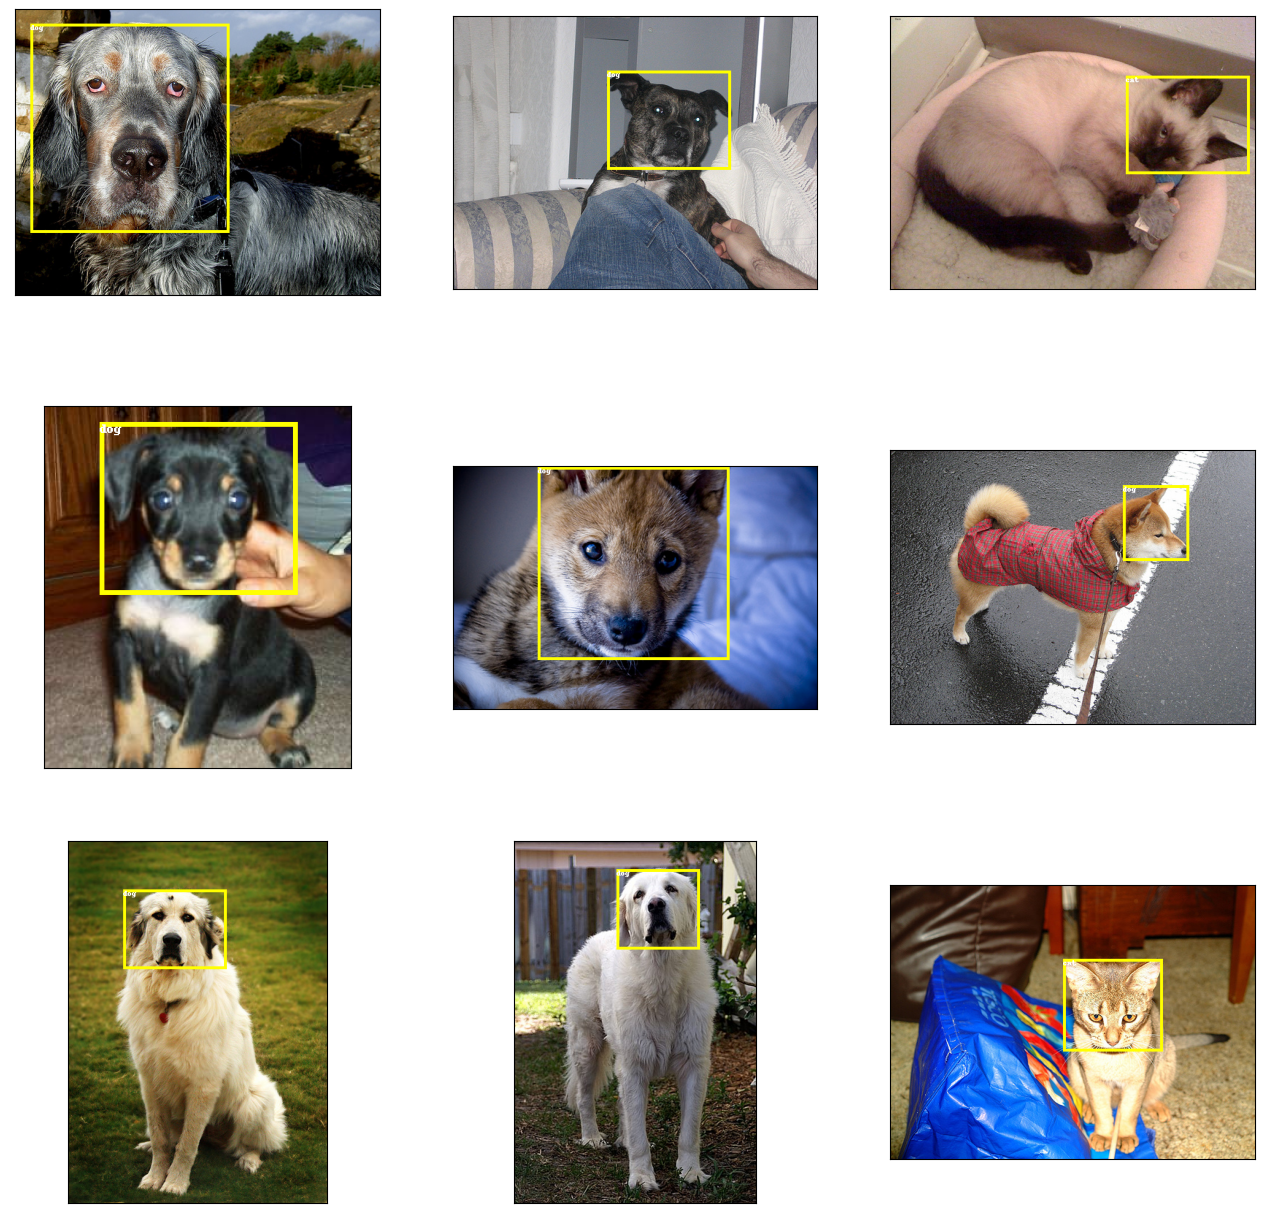

In [8]:
show_random_annotations(plt)

# SageMaker Setup

In [9]:
role = sagemaker.get_execution_role()
bucket_name = 'petssdata'
training_image = get_image_uri(boto3.Session().region_name,'object-detection',repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:latest


In [10]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [11]:
print('Total examples:', len(xml_files))

Total examples: 3686


In [12]:
for xml_file in tqdm(xml_files):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join('data/images/', annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:01<00:00, 3183.79it/s]


In [13]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [14]:
print(len(train_annots), len(train_images))

2701 2701


In [15]:
for image in train_images:
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

# Uploading Data to S3

In [16]:
sess = sagemaker.Session()

print('uploading data..')
s3_train_path = sess.upload_data(path='train', bucket= bucket_name , key_prefix = 'train')
print('training images uploaded')

s3_validation_path = sess.upload_data(path ='validation' , bucket = bucket_name , key_prefix = 'validation')
print('validation images uploaded')

s3_train_ann_path = sess.upload_data(path ='train_annotation', bucket = bucket_name , key_prefix ='train_annotation')
print('train_annotation images uploaded')


s3_validation_ann_path = sess.upload_data(path ='validation_annotation' , bucket = bucket_name , key_prefix = 'validation_annotation')
print('validation_annotation images uploaded')

uploading data..
training images uploaded
validation images uploaded
train_annotation images uploaded
validation_annotation images uploaded


In [17]:
s3_train_ann_path

's3://petssdata/train_annotation'

# SageMaker Estimator

In [32]:
model = sagemaker.estimator.Estimator(
    training_image , 
    role = role , 
    train_instance_type ='ml.p3.2xlarge',
    train_instance_count = 1,
    train_volume_size = 100,
    train_max_run = 36000,
    input_mode = 'File',
    output_path = 's3://petssdata/output',
    sagemaker_session = sess
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [33]:
model.set_hyperparameters(
    base_network = 'resnet-50',
    num_classes = 2,
    use_pretrained_model = 1,
    mini_batch_size = 16,
    epochs = 15 ,
    learning_rate = 0.001,
    optimizer ='sgd',
    lr_scheduler_step = '10',
    lr_scheduler_factor = 0.1,
    momentum = 0.9,
    weight_decay = 0.0005,
    overlap_threshold=0.5,
    nms_threshold = 0.45,
    image_shape = 512,
    num_training_samples = len(train_annots)
)

# Data Channels

In [34]:
from sagemaker.session import s3_input
train_data = s3_input(s3_train_path ,
                      distribution ='FullyReplicated', 
                      content_type='application/x-image',
                      s3_data_type='S3Prefix')
validation_data = s3_input(s3_validation_path ,
                      distribution ='FullyReplicated', 
                      content_type='application/x-image',
                      s3_data_type='S3Prefix')

train_annotation_data = s3_input(s3_train_ann_path ,
                      distribution ='FullyReplicated', 
                      content_type='application/x-image',
                      s3_data_type='S3Prefix')
validation_annotation_data = s3_input(s3_validation_ann_path ,
                      distribution ='FullyReplicated', 
                      content_type='application/x-image',
                      s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [35]:
data_channels = {
    'train': train_data,
    'validation':validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation':validation_annotation_data
}

In [36]:
data_channels

{'train': <sagemaker.inputs.s3_input at 0x7f83780d8df0>,
 'validation': <sagemaker.inputs.s3_input at 0x7f83705b2070>,
 'train_annotation': <sagemaker.inputs.s3_input at 0x7f8378083640>,
 'validation_annotation': <sagemaker.inputs.s3_input at 0x7f8370795eb0>}

# Model Training

In [38]:
model.fit(inputs=data_channels, logs=True)

2023-03-18 23:19:47 Starting - Starting the training job...
2023-03-18 23:20:12 Starting - Preparing the instances for training......
2023-03-18 23:21:16 Downloading - Downloading input data...............
2023-03-18 23:23:26 Training - Downloading the training image...
2023-03-18 23:23:57 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Mar 18 23:24:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                   

# Deploy Model

In [39]:
deployed_model= model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')
print('model deployed')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


----------!model deployed


# Predictions

In [40]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

985


In [41]:
deployed_model.content_type = 'image/jpeg'

In [42]:
index = 0

image_path = os.path.join(image_dir, images[index])
#image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results = json.loads(results)

preds = results['prediction']


In [43]:
preds

[[1.0,
  0.4487631022930145,
  0.1730622947216034,
  0.06974467635154724,
  0.6889292001724243,
  0.6164882183074951],
 [1.0,
  0.25618115067481995,
  0.2899501323699951,
  0.0,
  0.865446925163269,
  0.7512487769126892],
 [1.0,
  0.12899824976921082,
  0.4613591134548187,
  0.09734126925468445,
  0.8667255640029907,
  0.5673075914382935],
 [1.0,
  0.11737538874149323,
  0.11370638012886047,
  0.15213271975517273,
  0.7834619283676147,
  0.9693727493286133],
 [1.0,
  0.0613144226372242,
  0.31969666481018066,
  0.4924777150154114,
  0.7734712362289429,
  1.0],
 [1.0,
  0.06092005595564842,
  0.02038055658340454,
  0.01208767294883728,
  0.5588662028312683,
  0.7672892808914185],
 [1.0,
  0.05919904261827469,
  0.38282960653305054,
  0.3036569654941559,
  0.9754450917243958,
  0.9979162216186523],
 [1.0,
  0.049514252692461014,
  0.5288238525390625,
  0.2295498549938202,
  0.8162738084793091,
  0.8611856698989868],
 [1.0, 0.04023738577961922, 0.843014657497406, 0.8948973417282104, 1.0, 

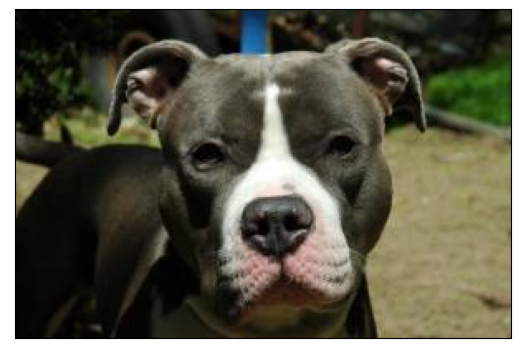

In [45]:
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = pred
    
    if score > 0.7:
        box = [w*xmin, h*ymin, w*xmax, h*ymax]

        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
    else:
        break

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)